### Employee Attrition using **CatBoost**

* L.S, ottobre 2021
* gestione delle **feature categoriche**
* importanza del **Learning rate**
* gestione dataset imbalance tramite **class weights**

Questo notebook è semplificato, rispetto alla versione completa (catboost1)

In [1]:
import pandas as pd
import numpy as np

# for reading data from Object Storage
from utils import read_from_object_storage, my_train_test_split, plot_cm, compute_auc
from utils import compute_prec_rec, compute_accuracy

from ads import set_auth

# usero' catboost
import catboost as cat

# per la confusion matrix ed altre metriche uso sklearn
# in utils.py
from sklearn.preprocessing import LabelEncoder

# grafici
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# this way we enable access to Object Storage and don't need to provide API keys
# OCI admin must have set-up a dynamic group for Notebooks, with proper policy
set_auth(auth='resource_principal')

In [3]:
# utility function and globals
# GLOBALS
FIGSIZE = (9, 6)

SEED = 42

# additional print
DEBUG = 0

#set the tracking uri to log runs on a tracking server
TRACKING_URI = "http://150.230.146.100:5000/"

# end globals

#
# Utility functions in utils.py
#

### Reading dataset from Object Storage

In [4]:
# input data from file in Object Storage
PREFIX = "oci://data_input@fr95jjtqbdhh/"
FILE_NAME = "orcl_attrition.csv"

# see in functions above
data_orig = read_from_object_storage(prefix=PREFIX, file_name=FILE_NAME)

# some columns are not needed. This is the list of columns that will be used
my_columns = ['Age', 'Attrition', 'EnvironmentSatisfaction', 'MaritalStatus', 'TravelForWork', 'SalaryLevel', 'JobFunction', 'CommuteLength', 'EducationalLevel', 'EducationField', 'MonthlyIncome', 
              'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'WorkLifeBalance']

# dataset filtrato eliminando le colonne non necessarie
data = data_orig[my_columns]

In [5]:
# tipologie di features e colonne
TARGET = 'Attrition'

# automatizziamo !!!
all_columns = sorted(data.columns)
features = sorted(list(set(all_columns) - set([TARGET])))

# per decidere, guarda statistiche dal Notebook EDA1
cat_columns = sorted(['Age', 'CommuteLength','EnvironmentSatisfaction','MaritalStatus', 'TravelForWork', 'JobFunction', 
                      'EducationalLevel', 'EducationField', 'OverTime', 
                      'StockOptionLevel', 'TrainingTimesLastYear',
                      'YearsSinceLastPromotion', 'WorkLifeBalance'])


# colonne numeriche, continue (tutte le altre)
num_columns = sorted(list(set(all_columns) - set(cat_columns) - set([TARGET])))

print('Colonna Target:', TARGET)
print()
print('Tutte le features:', features, len(features))
print()
print('Colonne categorical:', cat_columns, len(cat_columns))
print()
print('Colonne numeriche:', num_columns, len(num_columns))


# split TRAIN, TEST
# shuffle prima dello split TRAIN, TEST
FRAC = 0.90

data_train, data_test = my_train_test_split(data, frac=FRAC)

Colonna Target: Attrition

Tutte le features: ['Age', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'JobFunction', 'MaritalStatus', 'MonthlyIncome', 'OverTime', 'SalaryLevel', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsSinceLastPromotion'] 15

Colonne categorical: ['Age', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'JobFunction', 'MaritalStatus', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsSinceLastPromotion'] 13

Colonne numeriche: ['MonthlyIncome', 'SalaryLevel'] 2

Numero totale di campioni: 1470
Numero di campioni nel TRAIN SET: 1323
Numero di campioni nel TEST SET: 147


In [6]:
# separo X (features) ed y (target)
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# encode labels as 0, 1
le = LabelEncoder()

# fit the encoder
le.fit(y_train.values)

# encode train and test
y_train = le.transform(y_train.values)
y_test = le.transform(y_test.values)

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_columns]

### First run, without class weights

In [7]:
%%time
# First: try without addressing data imbalance

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':10
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 2min 35s, sys: 33.3 s, total: 3min 8s
Wall time: 10.9 s


In [8]:
# compute and register results
auc = compute_auc(model, x_test, y_test)
print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)
print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)
print('Accuracy on test set is:', acc)

AUC computed on the test set is: 0.8207
precision and recall computed on the test set are: prec: 0.7143 rec: 0.1852
Accuracy on test set is: 0.837


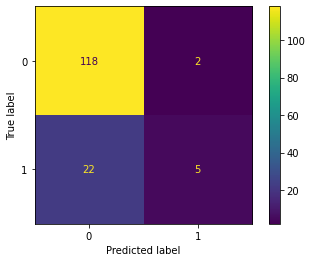

In [9]:
plot_cm(model, x_test, y_test)

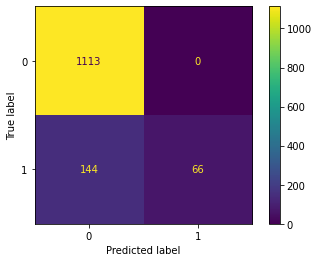

In [10]:
plot_cm(model, x_train, y_train)

### Second run, with class weights

In [11]:
%%time

# to address data imbalance
class_weights = dict({0:1, 1:5.5})

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':10,
          'class_weights':class_weights
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 2min 42s, sys: 35 s, total: 3min 17s
Wall time: 11.3 s


In [12]:
# compute and register results
auc = compute_auc(model, x_test, y_test)
print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)
print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)
print('Accuracy on test set is:', acc)

AUC computed on the test set is: 0.8022
precision and recall computed on the test set are: prec: 0.4839 rec: 0.5556
Accuracy on test set is: 0.81


### Evaluate confusion matrix on test set

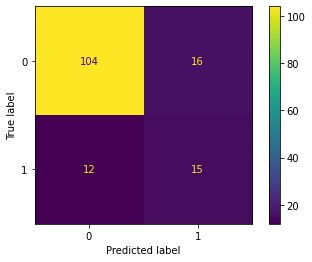

In [13]:
plot_cm(model, x_test, y_test)

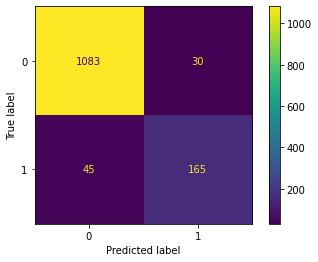

In [14]:
# c'è un certo overfitting...
plot_cm(model, x_train, y_train)

### Global explaination using feature importance

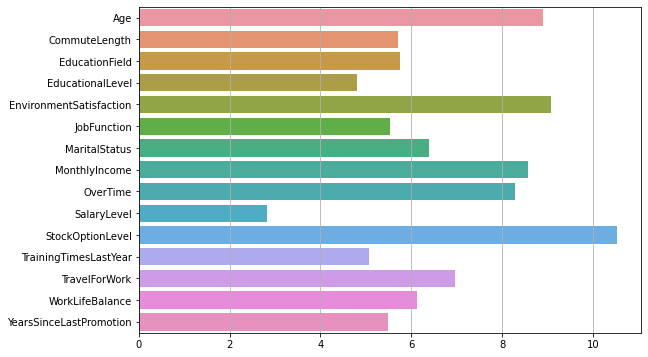

In [15]:
# eXplainability: Feature importance

plt.figure(figsize = FIGSIZE)
plt.grid(True)
sns.barplot(x = model.get_feature_importance(), y = features);